# "Electrode loading *vs* power limitations" comparison between PyBaMM and Matt Lacey's CellModel

Matt Lacey recently used his CellModel to test the sensitivity of power limitations as a function of electrode loading:

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">This question on what areal capacity (mAh/cm²) is ok for batteries and power/energy tradeoffs is quite important. But it's something we can quickly look at with the help of my cell modelling tool😉(with some mods)
https://github.com/mjlacey/cellmodels</p>&mdash; Matt Lacey (@mjlacey) <a href="https://twitter.com/mjlacey/status/1430841391920390147">August 26, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

This was accomplished by extending the model with this information:
* Area specific impedance (Ohmic drop from a 10s 5C pulse) estimated from the ANL work [Gallagher et al.](https://www.sciencedirect.com/science/article/abs/pii/S0378775310017477?via%3Dihub)
* Diffusion-limited C-rate (rate where Li+ in the electrolyte is depleted) estimated from [Heubner et al.](https://onlinelibrary.wiley.com/doi/10.1002/aenm.201902523)

It is interesting to compare predictions by [PyBaMM](https://www.pybamm.org/) as it is a physics-based model that contains more of the transport and kinetic phenomena that occur in a lithium-ion battery.

From the results shown it looks like the magnitudes and trends stack up well. The LGM50 cell used in this simulation is a particularly high energy density cell.

In [6]:
# Load pybamm & dependencies 
%pip install pybamm==0.4.0 -q    # install PyBaMM if it is not installed
import pybamm #version ==0.4.0
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import pickle

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))



Note: you may need to restart the kernel to use updated packages.
pybamm==0.4.0
numpy==1.18.1
pandas==1.0.1


In [39]:
#Plot details
fontsize = 12
figsz = (8,5)
dpi = 100

#import data if it exists
try:
    d = pickle.load(open('data.pkll', "rb"))
except:
    import warnings
    warnings.warn("You will need to run the second half of this notebook to generate the data")

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: You will need to run the second half of this notebook to generate the data
  


#### Choose areal capacity loadings to sweep through:

In [42]:
arealcap_array = np.arange(2,6,0.5)

## Sensitivty analysis results
---

### **Fig 1.** Cell-level energy density vs areal capacity 

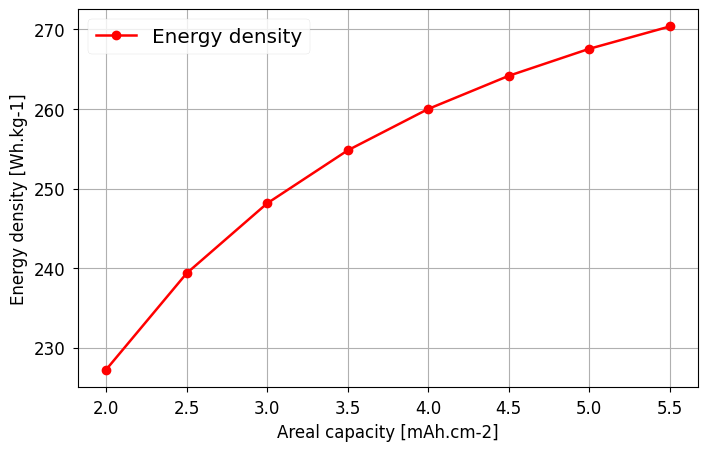

In [25]:
# Cell-level energy density vs areal capacity
data_array = []
for arealcap in arealcap_array:
    data = d[arealcap].Wh_per_kg[0]
    data_array = np.append(data_array,data)   
figure(figsize=figsz, dpi=dpi)
plt.plot(arealcap_array, data_array, "ro-",label="Energy density")
plt.xlabel('Areal capacity [mAh.cm-2]',fontsize=fontsize)
plt.ylabel('Energy density [Wh.kg-1]',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize*1.2)
plt.grid(True)
plt.show()

### **Fig 2.** Jelly roll area vs areal capacity

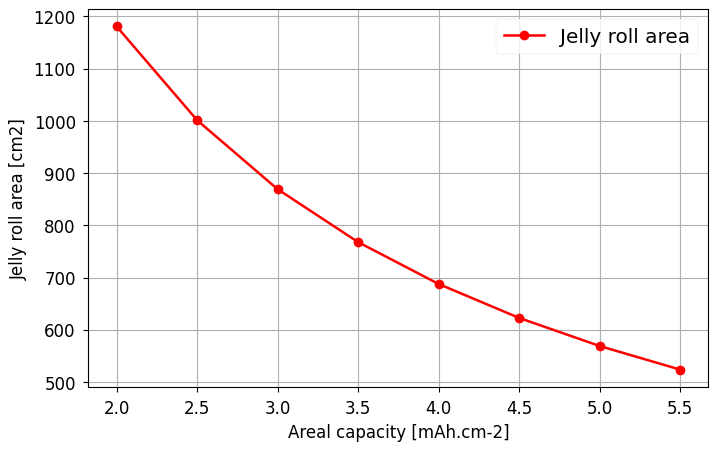

In [26]:
# Jelly roll area vs areal capacity
data_array = []
for arealcap in arealcap_array:
    data = d[arealcap].area[0]*10000 #m2 to cm2
    data_array = np.append(data_array,data)
figure(figsize=figsz, dpi=dpi)
plt.plot(arealcap_array, data_array, "ro-",label="Jelly roll area")
plt.xlabel('Areal capacity [mAh.cm-2]',fontsize=fontsize)
plt.ylabel('Jelly roll area [cm2]',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize*1.2)
plt.grid(True)
plt.show()

### **Fig 3.** Cell impedance vs areal capacity

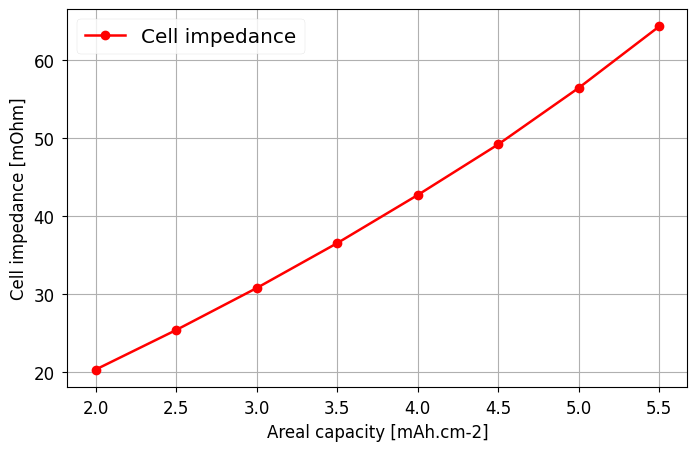

In [27]:
# Cell impedance vs areal capacity
data_array = []
for arealcap in arealcap_array:
    data = d[arealcap].impedance[0]*1000 #ohm to mohm
    data_array = np.append(data_array,data) 
figure(figsize=figsz, dpi=dpi)
plt.plot(arealcap_array, data_array, "ro-",label="Cell impedance")
plt.xlabel('Areal capacity [mAh.cm-2]',fontsize=fontsize)
plt.ylabel('Cell impedance [mOhm]',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize*1.2)
plt.grid(True)
plt.show()

### **Fig 4.** Diffusion-limited C-rate vs areal capacity

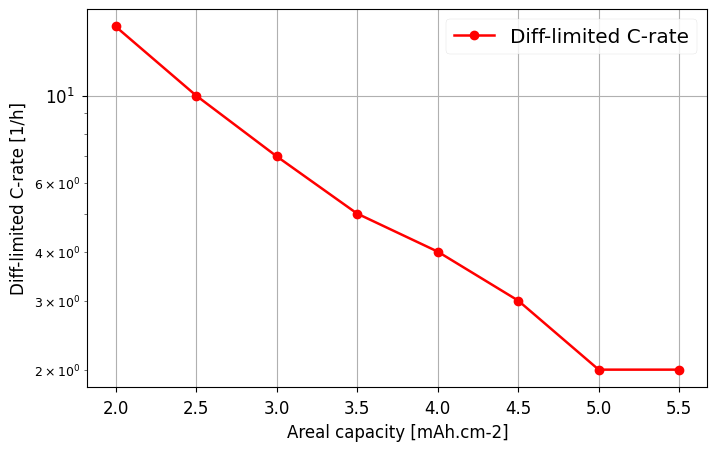

In [28]:
# DLC vs areal capacity
data_array = []
for arealcap in arealcap_array:
    data = d[arealcap].C_rate.iloc[-1]
    data_array = np.append(data_array,data) 
figure(figsize=figsz, dpi=dpi)
plt.plot(arealcap_array, data_array, "ro-",label="Diff-limited C-rate")
plt.xlabel('Areal capacity [mAh.cm-2]',fontsize=fontsize)
plt.ylabel('Diff-limited C-rate [1/h]',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize*1.2)
plt.grid(True)
plt.yscale('log')
plt.show()

### **Fig 5.** C-rate energy density map for different loadings
* With PyBaMM we can actually simulate the "true" achievable capacities at a given C-rate and mass loading, so we do this here:

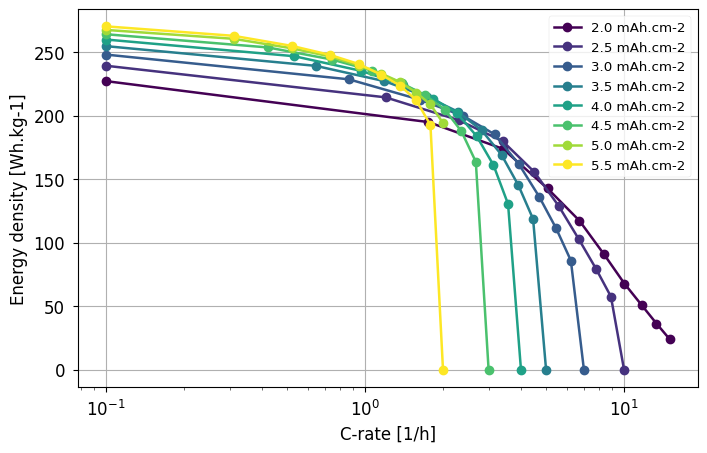

In [30]:
# C-rate vs energy density for difference loadings
plt.figure(figsize=figsz, dpi=dpi)
data_array = []
viridis = cm.get_cmap('viridis', np.size(arealcap_array))
for i, arealcap in enumerate(arealcap_array):
    C_rate = d[arealcap].C_rate
    Wh_per_kg = d[arealcap].Wh_per_kg
    plt.plot(C_rate, Wh_per_kg, "o-",label=str(arealcap)+' mAh.cm-2',color=viridis(i))
    plt.xlabel('C-rate [1/h]',fontsize=fontsize)
    plt.ylabel('Energy density [Wh.kg-1]',fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize*0.8)
    plt.grid(True)
    plt.xscale('log')
#     plt.yscale('log')
plt.show()

## Run these cells to actually generate the data
---

#### **Function 1.** Varying cell parameters from Chen2020

* Parameter set chosen is the LGM50 cell characterized in this paper: [Chen2020](https://iopscience.iop.org/article/10.1149/1945-7111/ab9050)
* In this study we keep the porosity, particle size, and NP-ratio constant so varying the areal loading is the same as varying the thickness of the electrodes

In [33]:
def set_params_arealcap(arealcap):
    chemistry = pybamm.parameter_sets.Chen2020
    parameter_values = pybamm.ParameterValues(chemistry=chemistry)

    thick = parameter_values['Positive electrode thickness [m]']
    h = parameter_values['Electrode height [m]']
    w = parameter_values['Electrode width [m]']
    a = h * w

    cap = parameter_values['Nominal cell capacity [A.h]']
    arealcap_old = 1000*cap/(a*10000) #get original cell areal capacity
    pybamm_area = a
    cap_new = (arealcap/1000)*(pybamm_area*10000) #scaling nominal capacity
    thick_new = thick*(arealcap)/(arealcap_old) #scaling new positive electrode thickness
    neg_thick = (thick_new/thick) * parameter_values['Negative electrode thickness [m]'] #maintaining original ~1.1 NP ratio
    
    #Adding new gemoetrical parameters
    parameter_values['Nominal cell capacity [A.h]'] = cap_new
    parameter_values['Negative electrode thickness [m]'] = neg_thick
    parameter_values['Positive electrode thickness [m]'] = thick_new
    
    return parameter_values

#### **Function 2.** Run PyBaMM discharge experiment
* Discharges cell at specified C-rate down to 3 V, unless it hits electrolyte depletion limit

In [34]:
def run_pybamm_model(parameter_values,C_rate):
    experiment = pybamm.Experiment(
        [("Discharge at {:.4f} C until 3.0 V".format(C_rate))],
        period="{:.4f} seconds".format(100 / C_rate)
    )
    model = pybamm.lithium_ion.DFN()
    solver = pybamm.CasadiSolver()
    sim = pybamm.Simulation(model,experiment=experiment,parameter_values=parameter_values,solver=solver)
    pybamm_area = parameter_values['Electrode height [m]'] * parameter_values['Electrode width [m]']
    try: #Catch situation where electrolyte depletion occurs
        sim.solve()
        sol = sim.solution
        dcap = sol["Discharge capacity [A.h]"].entries[-1] #areal discharge capacity
        V = np.mean(sol["Terminal voltage [V]"].entries)
        elyte_depletion = False
    except:
        elyte_depletion = True
        dcap = 0
        V = 0
    return elyte_depletion, dcap, V, pybamm_area

#### **Function 3.** Calculate area specific impedance 
* Simulates the ASI measured in from the Ohmic drop pulse experiment for a 10s 5C pulse discharge

In [35]:
def calc_ASI(arealcap):
    C_rate = 5 #5C HPP Pulse test
    parameter_values = set_params_arealcap(arealcap)
    experiment = pybamm.Experiment(
            [("Discharge at {:.4f} C for 10 seconds".format(C_rate))],
            period="{:.4f} seconds".format(0.1)
        )
    model = pybamm.lithium_ion.DFN()
    solver = pybamm.CasadiSolver()
    sim = pybamm.Simulation(model,experiment=experiment,parameter_values=parameter_values,solver=solver)
    pybamm_area = parameter_values['Electrode height [m]'] * parameter_values['Electrode width [m]']
    sim.solve()
    sol = sim.solution
    I = parameter_values["Current function [A]"]
    dV = (sol["Terminal voltage [V]"].entries[0]-sol["Terminal voltage [V]"].entries[-1])
    ASI = pybamm_area*dV/I #Ohms*m^2
    return ASI

#### **Function 4.** Adding in cylindrical cell casing and geometry
* We need to calculate the cell mass and jellyroll area required to calculate energy densities
* 21700 cylindrical cell format is chosen
* Jelly roll area is calculated using the archimedean spiral formula

In [36]:
#Get mass of cylindrical cell from pybamm parameter
def cylindrical_cell(arealcap):
#Pybamm parameters
    parameter_values = set_params_arealcap(arealcap)
    pybamm_cap = parameter_values['Nominal cell capacity [A.h]']
    pybamm_area = 0.5*(1000*pybamm_cap/arealcap)*1E-4 # 1cm2 #Single sided coat

    #21700 Cell components - taken from github.com/mjlacey/cellmodels/
    d_cell = 21E-3 #m 2170 cell diameter
    h_cell = 70E-3 #m 2170 cell height
    headspace = 6E-3 #m gap in top of can
    d_mandrel = 2.5E-3 #m void space in middle of cell
    can_thick = 1.65E-4 #m thickness of steel can
    can_dens = 7900 #kg/m3 density of steel can material
    can_mass = can_dens*can_thick*(np.pi*d_cell*d_cell*h_cell + 2*np.pi*(d_cell/2)**2) #kg

    #positive_electrode
    pos_thick = parameter_values['Positive electrode thickness [m]']
    pos_coat_density = parameter_values['Positive electrode density [kg.m-3]']
    pos_areal_coat_mass = pos_thick*pos_coat_density #kg/m2 of electrode
    pos_por = parameter_values['Positive electrode porosity']
    pos_mass = pos_areal_coat_mass*pybamm_area

    #negative_electrode
    neg_thick = parameter_values['Negative electrode thickness [m]']
    neg_coat_density = parameter_values['Negative electrode density [kg.m-3]']
    neg_areal_coat_mass = pos_thick*neg_coat_density #kg/m2 of electrode
    neg_por = parameter_values['Negative electrode porosity']
    neg_mass = neg_areal_coat_mass*pybamm_area

    #current collectors
    cc_neg_dens = parameter_values['Negative current collector density [kg.m-3]']
    cc_pos_dens = parameter_values['Positive current collector density [kg.m-3]']
    cc_neg_thick = parameter_values['Negative current collector thickness [m]']
    cc_pos_thick = parameter_values['Positive current collector thickness [m]']
    cc_pos_mass = cc_pos_thick*cc_pos_dens*pybamm_area
    cc_neg_mass = cc_neg_thick*cc_neg_dens*pybamm_area
   
    #separator 
    sep_dens = parameter_values['Separator density [kg.m-3]'] #effective density of polymer separator including porosity
    sep_por = parameter_values['Separator porosity']
    sep_thick = parameter_values['Separator thickness [m]']
    sep_mass = sep_dens*sep_thick*pybamm_area

    #electrolyte
    elyte_loading = 1.7 #mL/Ah electrolyte capacity ratio
    elyte_dens = 1220 #kg/m3 electrolyte liquid density

    elyte_mass = elyte_dens*pybamm_cap*elyte_loading*1E-6
    elyte_thick = (neg_thick*neg_por) + (pos_thick*pos_por) + (sep_thick*sep_por)
    elyte_vol = elyte_thick*pybamm_area
    elyte_mass_check = elyte_vol*elyte_dens #Sanity check: required mass of elyte to fill just the pore domains

    #Calculate areal mass and stack thickness
    jellyroll_areal_mass = (cc_pos_mass + 2*pos_mass + 2*sep_mass + 2*elyte_mass + 2*neg_mass + cc_neg_mass)/pybamm_area #kg/m2 of electrode double sided coatings
    stack_thickness = (cc_pos_thick + 2*pos_thick + 2*sep_thick + 2*neg_thick + cc_neg_thick) #m #double sided coatings

    #Wind up the total electrode mass into cylinder can
    a = stack_thickness/(2*np.pi)
    theta = (d_cell/2)*(2*np.pi)/stack_thickness
    l_all = (a/2)*(theta*np.sqrt(1+theta**2) + np.log(theta + np.sqrt(1+theta**2)))
    theta_mandrel = (d_mandrel/2)*(2*np.pi)/stack_thickness
    l_inner = (a/2)*(theta_mandrel*np.sqrt(1+theta_mandrel**2) + np.log(theta_mandrel + np.sqrt(1+theta_mandrel**2)))
    l_winding = l_all-l_inner
    h = h_cell-headspace-2*can_thick
    area = h*l_winding

    #Summary
    jellyroll_mass = jellyroll_areal_mass*area
    total_cell_mass = can_mass + jellyroll_mass
    
    return total_cell_mass, area, jellyroll_mass, stack_thickness


#### **Function 5.** Diffusion-limiting C-rate
* Binary searches through C-rates to force the experiment to terminate due to electrolyte depletion
* This is slow and not smart 
* C-rate given to the nearest 0.5

In [37]:
def calc_limiting_C_rates(arealcap):
    C_rate_array = np.array([0,30,5])
    C_rate = C_rate_array[-1]

    parameter_values = set_params_arealcap(arealcap)
    elyte_depletion = False

    while C_rate != C_rate_array[-2]:
        elyte_depletion, dcap, V, pybamm_area = run_pybamm_model(parameter_values,C_rate)
        if elyte_depletion == True: 
            A = C_rate_array[C_rate_array<C_rate][-1]
            C_rate = np.round(C_rate+A)/2
            C_rate_array = np.append(C_rate_array, C_rate)
        else:
            A = C_rate_array[C_rate_array>C_rate][-1]
            C_rate = np.round(C_rate+A)/2
            C_rate_array = np.append(C_rate_array, C_rate)
        C_rate = C_rate_array[-1]

    lim_C_rate = C_rate #Array of limiting C-rates for the arealcap_array values
    
    return lim_C_rate

#### **Function 6.** Calculate results 
* Loops through areal capacities
* Finds the max C-rate and makes a range of C-rates based on that
* Based on the areal capacity and C-rate will calculate the energy density and other properties
* Loads all of this into dataframes in a dictionary

In [38]:
def calc_cellenergydensity(arealcap_array,n_c_rates):
    
    d = {}
    
    for arealcap in arealcap_array:
        print('arealcap')
        print(arealcap)
        area_array = []
        thick_array = []
        Wh_array = []
        Wh_per_kg_array = []
        mass_array = []
        cap_array = []
        V_array = []
        ASI_array = []
        impedance_array = []
    
        d[arealcap] = pd.DataFrame()
        
        lim_C_rate = calc_limiting_C_rates(arealcap)
        print('lim C')
        print(lim_C_rate)
        C_rate_array =np.linspace(0.1,lim_C_rate,n_c_rates) #C/10 is the pseudo OCV
        
        for C_rate in C_rate_array:
            parameter_values = set_params_arealcap(arealcap)
            total_cell_mass, area, jellyroll_mass, stack_thickness =  cylindrical_cell(arealcap)
            ASI = calc_ASI(arealcap)
            impedance = ASI/area

            impedance_array = np.append(impedance_array,impedance)
            area_array = np.append(area_array, area)
            thick_array = np.append(thick_array,stack_thickness)
            mass_array = np.append(mass_array, total_cell_mass)

            elyte_depletion, dcap, V, pybamm_area = run_pybamm_model(parameter_values,C_rate)
            Wh = 2*dcap*V*(area/pybamm_area) #double coated area
            cell_Wh_per_kg = Wh/total_cell_mass
            Wh_array = np.append(Wh_array, Wh)
            Wh_per_kg_array = np.append(Wh_per_kg_array, cell_Wh_per_kg)
            cap_array = np.append(cap_array,2*dcap*(area/pybamm_area)) #double coated area
            V_array = np.append(V_array,V)
            
            
            
        sim_dict = {'C_rate': C_rate_array,
                    'Wh_per_kg': Wh_per_kg_array,
                    'mass': mass_array,
                    'area': area_array,
                    'thick': thick_array,
                    'impedance':impedance_array}

        d[arealcap] = pd.DataFrame(sim_dict)
        
        
    return d       

## **Calculation.** Actually perform the calculation
* This might take a while

In [39]:
arealcap_array = np.arange(2,6,0.5)
n_c_rates = 10

d = calc_cellenergydensity(arealcap_array,n_c_rates)
d

#Save the data to load up later
import pickle
filename = 'data.pkl'
a_file = open(filename, "wb")
pickle.dump(d, a_file)
a_file.close()
output = pickle.load(open(filename, "rb"))
# print(output)

arealcap
2.0


At t = 0.100383, , mxstep steps taken before reaching tout.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interfa

lim C
15.0


At t = 0.0983453, , mxstep steps taken before reaching tout.
At t = 0.0435518, , mxstep steps taken before reaching tout.


arealcap
2.5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

lim C
10.0


2021-09-01 17:51:46,168 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 10.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.




arealcap
3.0


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00129981 an

lim C
7.0


2021-09-01 17:52:27,194 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 7.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.




arealcap
3.5


2021-09-01 17:52:28,660 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 5.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.


2021-09-01 17:52:35,151 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 5.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.




lim C
5.0


2021-09-01 17:53:07,304 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 5.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.




arealcap
4.0


2021-09-01 17:53:08,722 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 5.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.


2021-09-01 17:53:12,144 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 4.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.


2021-09-01 17:53:16,919 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 4.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.




lim C
4.0


2021-09-01 17:53:48,216 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 4.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.




arealcap
4.5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

lim C
3.0


2021-09-01 17:54:27,029 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 3.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.




arealcap
5.0


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

lim C
2.0
arealcap
5.5


psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

lim C
2.0


2021-09-01 17:55:51,155 - [WARNING] simulation.solve(741): 

	Experiment is infeasible: 'event: Zero electrolyte concentration cut-off' was triggered during 'Discharge at 2.0000 C until 3.0 V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.




{2.0:       C_rate   Wh_per_kg      mass      area     thick  impedance
0   0.100000  227.234342  0.075622  0.118083  0.000184   0.020328
1   1.755556  194.989866  0.075622  0.118083  0.000184   0.020328
2   3.411111  173.850580  0.075622  0.118083  0.000184   0.020328
3   5.066667  142.659649  0.075622  0.118083  0.000184   0.020328
4   6.722222  117.347130  0.075622  0.118083  0.000184   0.020328
5   8.377778   90.692018  0.075622  0.118083  0.000184   0.020328
6  10.033333   67.730664  0.075622  0.118083  0.000184   0.020328
7  11.688889   50.847876  0.075622  0.118083  0.000184   0.020328
8  13.344444   36.242168  0.075622  0.118083  0.000184   0.020328
9  15.000000   23.931366  0.075622  0.118083  0.000184   0.020328, 2.5:    C_rate   Wh_per_kg      mass      area     thick  impedance
0     0.1  239.347816  0.076078  0.100122  0.000217   0.025397
1     1.2  214.466807  0.076078  0.100122  0.000217   0.025397
2     2.3  196.495694  0.076078  0.100122  0.000217   0.025397
3     3.4 